In [1]:
import pennylane as qml
import jax
from jax import numpy as jnp
import optax
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Setting 64-bit precision as default type
jax.config.update("jax_enable_x64",True)

### RBF Kernel:
$$
K(x, y) = \frac{1}{c} \sum_{i=1}^c \exp\left(-\frac{(x - y)^2}{2\sigma_i^2}\right).
$$

### squared MMD Loss Function
$$
\mathcal{L} = \mathbb{E}_{x,y \sim p_0} [K(x, y)] - 2 \mathbb{E}_{x \sim p_0, y \sim T} [K(x, y)] + \mathbb{E}_{x,y \sim T} [K(x, y)]
$$


In [3]:
#Defining squared maximum mean discrepancy (MMD) Loss function for Radial basis function (RBF) kernel
class MMD:
    
    def __init__(self, scales, space):
        #scales = list of guassian width (sigma)
        #space = data points x and y
        
        gammas = 1 / (2*(scales**2)).reshape(-1, 1, 1)  # Reshape gammas to (2, 1, 1)
        sq_dists = jnp.abs(space[:,None] - space[None,:])**2
        self.K = jnp.sum(jnp.exp(-gammas * sq_dists), axis=0) / len(scales)
        print(np.shape(self.K))
        self.scales = scales
        
    def k_expval(self,px,py):
        return px @ self.K @ py
    
    def __call__(self,px,py):
        pxy = px-py
        return self.k_expval(pxy,pxy)


In [4]:
#defining class QCBM that holds qcbm and objective function that has to be minimized
from functools import partial

class QCBM:
    
    def __init__(self, circ, mmd, py):
        self.circ = circ    #qcbm circuit
        self.mmd = mmd      #loss obtained
        self.py = py        #target distribution pi(x)
        
    @partial(jax.jit, static_argnums=0)
    def mmd_loss(self,params):
        px = self.circ(params) #obtained distribution p(x)
        print("Obtained distribution (px):",px)
        return self.mmd(px,self.py), px

### learning a misture of Gaussians

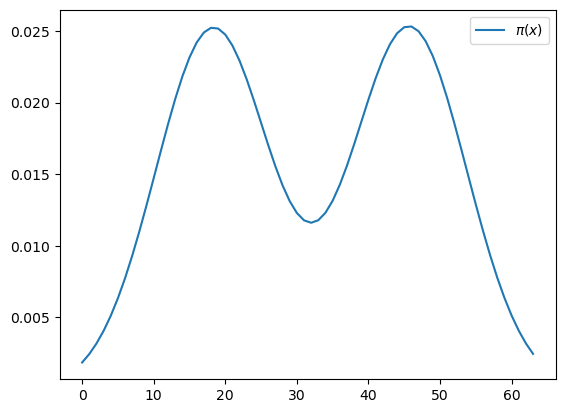

In [5]:
def mixture_gaussian_pdf(x, mus, sigmas):
    mus, sigmas = np.array(mus), np.array(sigmas)
    vars = sigmas**2
    values = [
        (1 / np.sqrt(2 * np.pi * v)) * np.exp(-((x - m) ** 2) / (2 * v)) for m, v in zip(mus, vars)
    ]
    values = np.sum([val / sum(val) for val in values], axis=0)
    return values / np.sum(values)


n_qubits = 6
x_max = 2**n_qubits
x_input = np.arange(x_max)
mus = [(2 / 7) * x_max, (5 / 7) * x_max]    #mu1 and mu2 for 2 gaussians
sigmas = [x_max / 8] * 2                    #sigma1 and sigma2 fro 2 gaussians
data = mixture_gaussian_pdf(x_input, mus, sigmas)

plt.plot(data, label=r"$\pi(x)$")
plt.legend()
plt.show()

Initial circuit probabilities: [1.58191355e-01 3.83114336e-02 9.60403731e-03 2.09694548e-03
 1.20960318e-02 1.34310185e-02 2.58278341e-02 2.36788981e-02
 1.22261351e-03 4.88120562e-03 1.17639947e-04 8.65326356e-03
 7.84162208e-03 1.72838356e-02 2.52521035e-02 1.88255411e-03
 5.32564306e-03 1.70513762e-02 1.81553210e-03 1.01926246e-02
 2.13269244e-02 1.17753810e-03 4.10786011e-03 9.24228300e-03
 3.46623809e-03 1.42721911e-02 1.69481512e-02 2.47651150e-02
 1.51638886e-02 3.76170463e-02 4.54371108e-03 1.42109274e-03
 4.45271719e-02 3.70083974e-02 3.29677003e-03 4.11083022e-03
 1.61890777e-02 1.00911943e-02 1.00583901e-03 9.35286847e-03
 9.53724179e-03 2.00179900e-04 4.85215883e-02 4.78305874e-03
 2.78183287e-02 1.33712480e-02 1.84758507e-03 3.32623558e-02
 5.44300977e-03 4.08088432e-03 8.37563283e-03 7.34094400e-03
 3.33103202e-03 5.31661561e-03 1.60429712e-02 6.18226936e-03
 6.80795980e-03 2.17932573e-02 1.36187559e-02 2.17136078e-02
 3.01935324e-02 3.37665588e-02 1.40718314e-03 1.085244

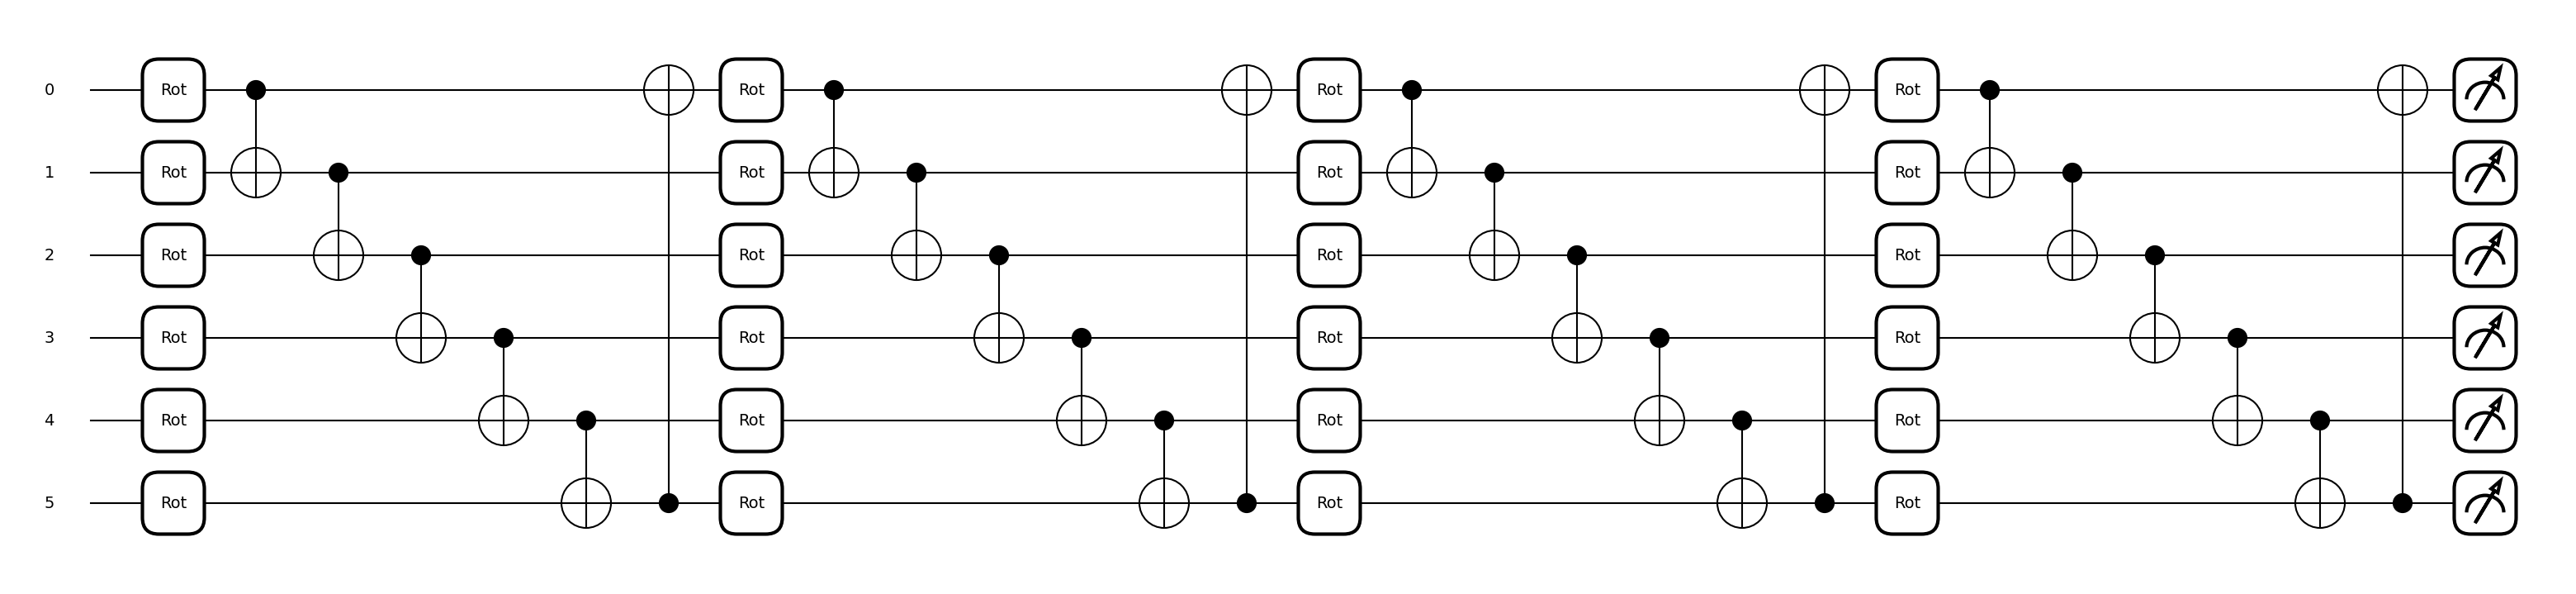

In [6]:
#Defining an ansatz quantum circuit to be used for qcbm

dev = qml.device("default.qubit", wires=n_qubits)

n_layers = 4
wshape = qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_qubits)
weights = np.random.random(size=wshape)

@qml.qnode(dev)
def circuit(weights):
    qml.StronglyEntanglingLayers(weights=weights,wires=range(n_qubits),ranges=[1]*n_layers)
    return qml.probs()

jit_circuit = jax.jit(circuit)
print("Initial circuit probabilities:", circuit(weights))

qml.draw_mpl(circuit, level="device")(weights)
plt.show()

In [7]:
print(weights)

[[[6.29040843e-02 8.76858807e-01 1.87904891e-01]
  [5.65710423e-01 3.48797295e-01 6.84566854e-01]
  [9.59547526e-01 9.61339837e-02 8.16348895e-01]
  [4.30811564e-01 4.48966380e-01 3.12128398e-01]
  [9.33195241e-01 8.37827709e-01 6.01500288e-02]
  [2.97386602e-01 7.56774087e-01 3.57314847e-02]]

 [[3.83118285e-01 4.52054145e-01 5.24631456e-01]
  [3.41196738e-01 2.31143435e-01 8.31017036e-01]
  [7.58590612e-01 6.95308637e-01 9.06662254e-01]
  [4.08776631e-01 7.97378319e-01 1.59928375e-01]
  [9.86899834e-01 1.40868683e-01 5.03443267e-04]
  [6.90465066e-01 5.27727997e-01 4.02882832e-01]]

 [[4.14795552e-01 3.86254105e-02 4.42180739e-01]
  [1.44436242e-01 9.64625686e-01 6.16020731e-01]
  [6.78593459e-01 7.35128059e-01 3.11826919e-01]
  [4.09661298e-01 4.92243383e-03 9.21750048e-01]
  [6.78537965e-01 7.49826570e-01 2.73933771e-01]
  [9.67426952e-01 2.14603772e-01 2.48302699e-01]]

 [[3.16446595e-01 4.33628036e-01 4.53966129e-01]
  [4.12467892e-01 7.42418832e-01 6.04255439e-01]
  [3.10664223e

In [8]:
#Training

@jax.jit
def update_step(params, opt_state):
    
    
    ###################################
    (loss_val, qcbm_probs), grads = jax.value_and_grad(qcbm.mmd_loss, has_aux=True)(params)
    #######################################
    
    
    #grads = jnp.clip(grads,1e-8,None)
    updates, opt_state = opt.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    #params = jnp.clip(params,1e-8,None)
    kl_div = -jnp.sum(qcbm.py * jnp.nan_to_num(jnp.log(qcbm_probs / qcbm.py)))
    return params, opt_state, loss_val, kl_div

In [9]:
# bandwidth = jnp.array([0.25,60])
# space = jnp.arange(2**n_qubits)

# mmd = MMD(bandwidth,space=space)
# qcbm = QCBM(jit_circuit,mmd,data)

# loss1, px = qcbm.mmd_loss(weights)
# print(loss1)

In [10]:
#Lets optimize the above circuit with sqaured MMD loss function

bandwidth = jnp.array([0.25,60])
space = jnp.arange(2**n_qubits)

mmd = MMD(bandwidth,space=space)
qcbm = QCBM(jit_circuit,mmd,data)

opt = optax.adam(learning_rate=0.1)
opt_state = opt.init(weights)

history = []
divs = []
n_iterations = 200
#print(weights)
for i in range(n_iterations):
    weights, opt_state, loss_val, kl_div = update_step(weights, opt_state)

    if i%10 == 0:
        print(f"Step: {i} Loss: {loss_val} KL_div:{kl_div}")
        #print(weights)
    
    history.append(loss_val)
    divs.append(kl_div)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


(64, 64)
Obtained distribution (px): Traced<ShapedArray(float64[64])>with<DynamicJaxprTrace(level=4/0)>
Step: 0 Loss: 0.022438895555035043 KL_div:0.8974754120847437
Step: 10 Loss: 0.003399305166477706 KL_div:0.3244142373750665
Step: 20 Loss: 0.0018003290312947906 KL_div:0.18930158585556664
Step: 30 Loss: 0.0009182870299145256 KL_div:0.07621396479510198
Step: 40 Loss: 0.0005163904306460542 KL_div:0.04053669627880377
Step: 50 Loss: 0.000322126447132824 KL_div:0.03250258853787482
Step: 60 Loss: 0.000243986373402709 KL_div:0.02387588686543318
Step: 70 Loss: 0.00019876182958738 KL_div:0.02285508923756785
Step: 80 Loss: 0.0001640788276407091 KL_div:0.018995305277614623
Step: 90 Loss: 0.00014045981854674225 KL_div:0.017930057209231416
Step: 100 Loss: 0.00012278798397180534 KL_div:0.016818517908904686
Step: 110 Loss: 0.00010992535738587994 KL_div:0.015581640826847591
Step: 120 Loss: 9.86927212429415e-05 KL_div:0.014152119863634093
Step: 130 Loss: 8.846149139750491e-05 KL_div:0.0124347096584123

<>:3: SyntaxWarning: invalid escape sequence '\p'
<>:3: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_9322/2824532080.py:3: SyntaxWarning: invalid escape sequence '\p'
  plt.plot(range(x_max),data,linestyle='-',label='$\pi(x)$')


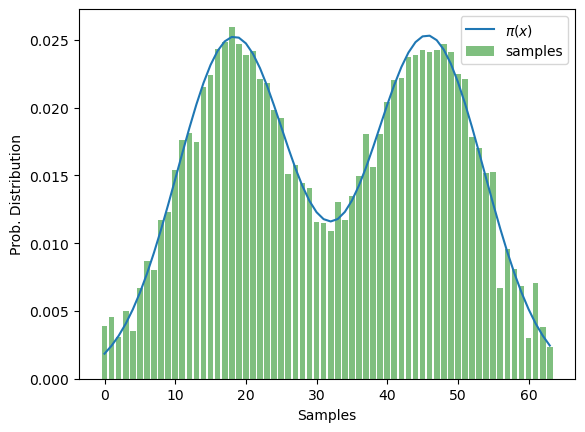

In [11]:
qcbm_probs = qcbm.circ(weights)

plt.plot(range(x_max),data,linestyle='-',label='$\pi(x)$')
plt.bar(range(x_max),qcbm_probs,color='green',alpha=0.5,label='samples')

plt.xlabel("Samples")
plt.ylabel("Prob. Distribution")

plt.legend()
plt.show()